#### ANL Sprint 2017

HSC-DR1 LSS Sprint:
Addressing the first task here:
https://github.com/LSSTDESC/HyperSupremeStructure-HSC-LSS/blob/master/SprintWeekDiary.md, that is comparingg Depth (limiting magnitude) from three methods:
1. Using Javi's method
2. Binning 5*flux_error for all galaxies in each pixel.
3. Using the random sky_std as described in https://hsc-release.mtk.nao.ac.jp/doc/index.php/random-points-for-dr1/. 

For each of these, we have the mean depth and depth variance for each of the five bands.

##### Need a quantitative comparison of the outputs from the three methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import os
from astropy.io import fits

from astropy.table import Table
import healpy as hp
from collections import OrderedDict
from matplotlib import cm
import copy

from dataCleanUp import dataCleanUp
from addSNR import addSNR
from createMaps import createMeanStdMaps
from mpl_toolkits.axes_grid1 import ImageGrid

import estDepth

Read in the data. Reading the latest ones: now have the random Table for the wide GAMA15H field.

In [2]:
HSCdatapath= '/global/cscratch1/sd/damonge/HSC/'
HSCFiles= os.listdir(HSCdatapath)
HSCFiles= ['HSC_WIDE_GAMA15H_forced.fits', 'HSC_WIDE_GAMA15H_random.fits'] # now random have is primary

In [3]:
HSCFiles= [HSCdatapath+f for f in HSCFiles]
HSCFiles

['/global/cscratch1/sd/damonge/HSC/HSC_WIDE_GAMA15H_forced.fits',
 '/global/cscratch1/sd/damonge/HSC/HSC_WIDE_GAMA15H_random.fits']

In [4]:
HSCdata= {}
for filename in HSCFiles:
    key= filename.split('WIDE_')[1].split('.fits')[0]
    dat = Table.read(filename, format='fits')
    HSCdata[key] = dat.to_pandas()
    
HSCFieldTag= key.split('_')[0]  # just the field tag.

In [5]:
# clean up
for key in HSCdata:
    print key
    HSCdata[key]= dataCleanUp(HSCdata[key])

GAMA15H_random
Given size of the dataframe:  (8121501, 60)
Dropped 30 isnull columns.
Dropped 8121471 rows since they contained nan entries.
idetect_is_primary in dataframe, so dropping objects with idetect_is_primary= False.
Dropped 2022870 rows based on idetect_is_primary= False.
Final size of the dataframe:  (6098631, 29)

GAMA15H_forced
Given size of the dataframe:  (7681225, 196)
Dropped 98 isnull columns.
Dropped 7681127 rows since they contained nan entries.
Final size of the dataframe:  (6139128, 98)



Added the columns. Now plotting the distribution.


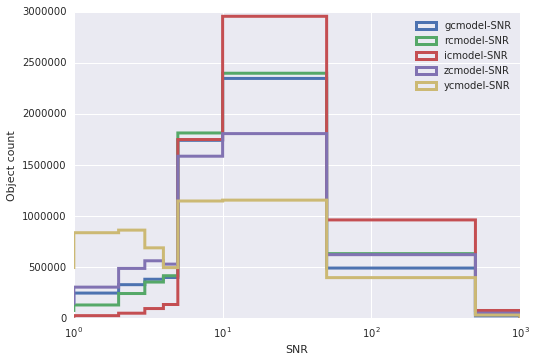

In [6]:
# add SNR columns to the forced catalog.
HSCdata['GAMA15H_forced'], SNCols= addSNR(HSCdata['GAMA15H_forced'])

In [7]:
import flatmaps as fm
flatSkyGrid= fm.FlatMapInfo([212.5,222.],[-2.,2.], dx=0.057,dy=0.057)

### Estimate 5$\sigma$ depth 

In [8]:
bands= ['i']
SNRthreshold= 5
depthMap, depthMap_var= {}, {}

### Method 1: Javi's

Creating i-band 5sigma depth maps


/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


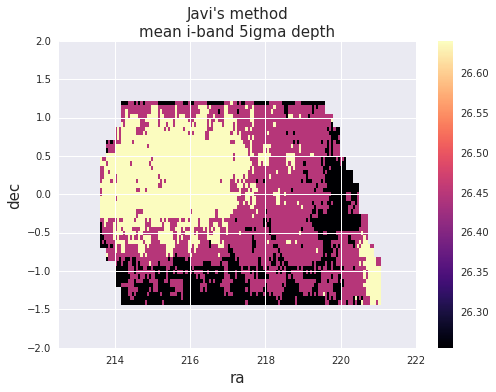

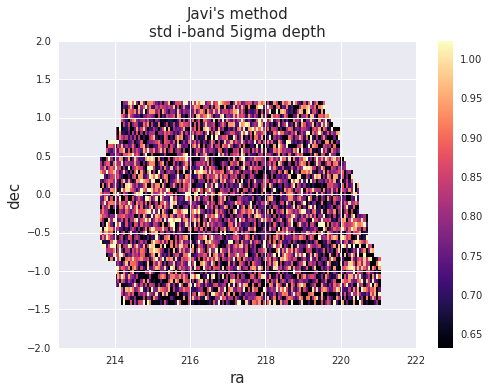

In [9]:
# create the 5sigma depth maps for each filter, using cmodel mags. plot skymaps + cartview.
HSCField= 'GAMA15H_forced'
method= 'Javis'
depthMap[method], depthMap_var[method]= {}, {} 
for band in bands:
    key= '%scmodel'%band
    out= estDepth.javis_method(HSCdata[HSCField]['ra'], HSCdata[HSCField]['dec'], band,
                               mags= HSCdata[HSCField]['%s_mag'%key],
                               snr= HSCdata[HSCField]['%s-SNR'%key],
                               flatSkyGrid= flatSkyGrid,
                               SNRthreshold= SNRthreshold, plotMaps= True,
                               saveMaps= False, outputDir= None)    
    depthMap[method][band], depthMap_var[method][band]= out

### Method 2: 
Bin 5*flux_error for all galaxies in each pixel.



Creating i-band 5sigma depth maps


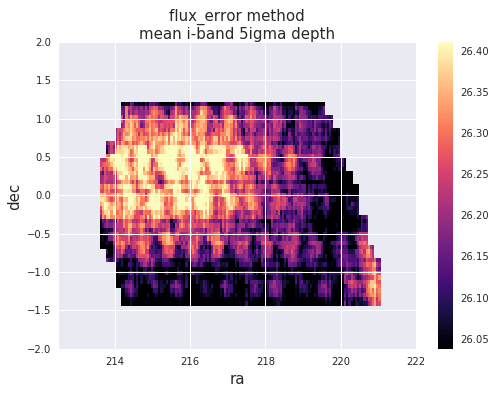

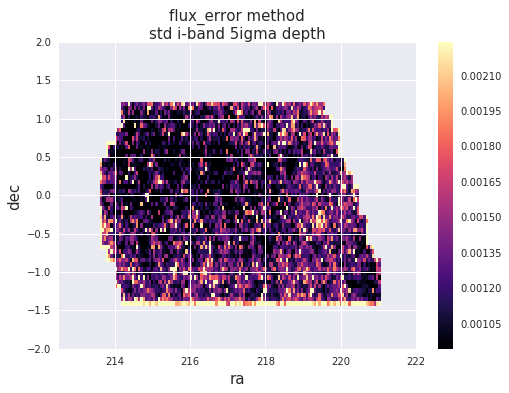

In [10]:
HSCDataKey= 'GAMA15H_forced'

method= 'FluxErr'
depthMap[method], depthMap_var[method]= {}, {} 


for band in bands:
    out= estDepth.flur_err_method(HSCdata[HSCDataKey]['ra'], HSCdata[HSCDataKey]['dec'],
                               HSCdata[HSCDataKey]['%scmodel_flux_err'%band],
                                band, flatSkyGrid, SNRthreshold= 5., plotMaps= True,
                                  saveMaps= False, outputDir= None)
    depthMap[method][band], depthMap_var[method][band]= out

### Method 3: 
Using the random sky_std as described here: https://hsc-release.mtk.nao.ac.jp/doc/index.php/random-points-for-dr1/

Creating i-band 5sigma depth maps


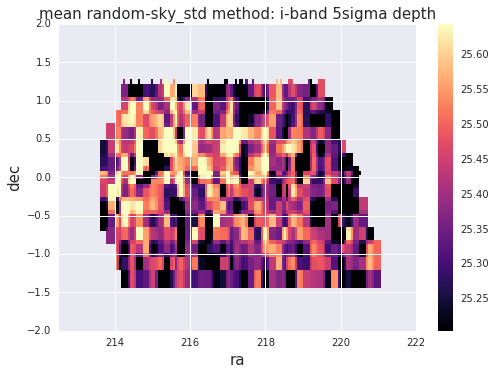

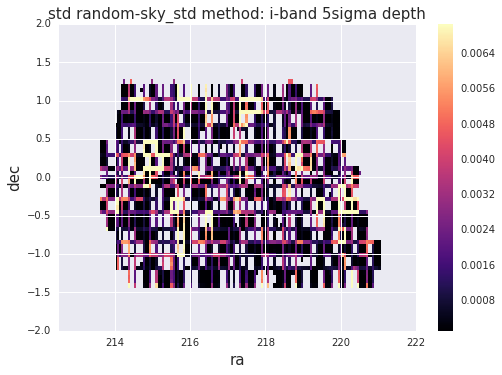

In [11]:
HSCDataKey= 'GAMA15H_random'

method= 'RandomSkyStd-isPrimary'
depthMap[method], depthMap_var[method]= {}, {} 
for band in bands:
    out= estDepth.random_sky_std_method(HSCdata[HSCDataKey]['ra'], HSCdata[HSCDataKey]['dec'],
                               HSCdata[HSCDataKey]['%ssky_std'%band],
                                band, flatSkyGrid, SNRthreshold= 5., plotMaps= True,
                                  saveMaps= False, outputDir= None)
    depthMap[method][band], depthMap_var[method][band]= out

Compare with saved data

In [12]:
outputDir= 'maps/'
depthFiles= os.listdir(outputDir)
depthFiles= [f for f in depthFiles if not f.__contains__('std')] # ignore the std across the maps for now
depthFiles= [f for f in depthFiles if f.__contains__('i-band')] # ignore ~isPrimary maps
old_depthMap= {}


for filename in depthFiles:
    print filename
    splits= filename.split('-band_')
    band= splits[0][-1:]
    method= splits[1].split('Method')[0]
    
    if method not in old_depthMap.keys(): old_depthMap[method]= {}   
    old_depthMap[method][band]= fm.read_flat_map(outputDir+filename)[1]
    
print ''
depthFiles= os.listdir(outputDir)
depthFiles= [f for f in depthFiles if f.__contains__('std')] # ignore the std across the maps for now
depthFiles= [f for f in depthFiles if f.__contains__('i-band')] # ignore ~isPrimary maps
old_depthMap_var= {}

for filename in depthFiles:
    print filename
    splits= filename.split('-band_')
    band= splits[0][-1:]
    method= splits[1].split('Method')[0]
    
    if method not in old_depthMap_var.keys(): old_depthMap_var[method]= {}   
    old_depthMap_var[method][band]= fm.read_flat_map(outputDir+filename)[1]

depthMap_i-band_JavisMethod.npz
depthMap_i-band_RandomSkyStd-isPrimaryMethod.npz
depthMap_i-band_FluxErrMethod.npz

depthMap_std_i-band_RandomSkyStd-isPrimaryMethod.npz
depthMap_std_i-band_FluxErrMethod.npz
depthMap_std_i-band_JavisMethod.npz


In [13]:
for band in bands:
    for method in depthMap:
        print method
        ind= np.where(~np.isnan(depthMap[method][band]))
        ind2= np.where(~np.isnan(old_depthMap[method][band]))
        print 'old, new means match: ', np.allclose(depthMap[method][band][ind], old_depthMap[method][band][ind2])
        print ''

FluxErr
old, new means match:  True

RandomSkyStd-isPrimary
old, new means match:  True

Javis
old, new means match:  True



### Comparison

Compare the plots from saved data and the ones calculated here.

In [14]:
cmap = cm.magma

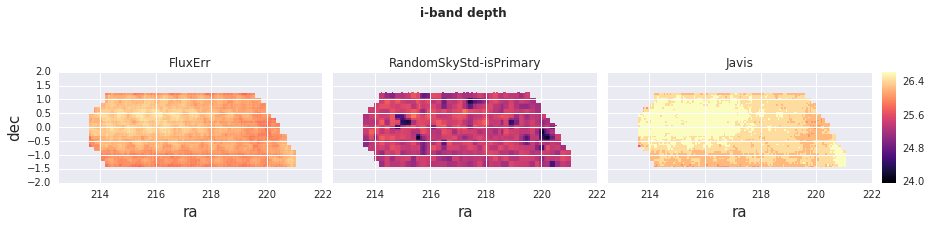

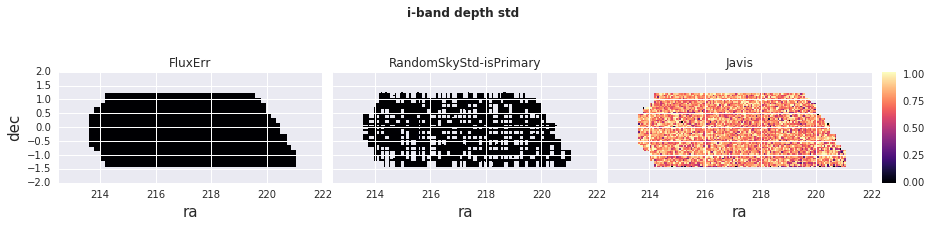

In [15]:
xlabel, ylabel= 'ra', 'dec'
for band in bands:
    # plot the depth for each method.
    fig = plt.figure(figsize=(15, 10))
    # set up for colorbar
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(1,3), axes_pad=0.15, share_all= True, cbar_location="right",
                     cbar_mode="single", cbar_size="5%", cbar_pad=0.15,
                     )
    # since have three maps, need colorange that ~works for all.
    colorMin= 100
    colorMax= -100
    for mInd, method in enumerate(depthMap):
        ind= np.where(depthMap[method][band]>0)[0]
        colorMin= min(colorMin, np.percentile(depthMap[method][band][ind], 0))
        colorMax= max(colorMin, np.percentile(depthMap[method][band][ind], 95))
    # plot
    for mInd, method in enumerate(depthMap):
        ax= grid[mInd]
        image= ax.imshow(depthMap[method][band].reshape([flatSkyGrid.ny,flatSkyGrid.nx]),
                         origin='lower', interpolation='nearest',
                         aspect='equal', extent=[flatSkyGrid.x0, flatSkyGrid.xf, flatSkyGrid.y0, flatSkyGrid.yf],
                         vmin= colorMin, vmax= colorMax, cmap= cmap)
        ax.set_title(method)
        ax.set_xlabel(xlabel,fontsize=15)
        ax.set_ylabel(ylabel,fontsize=15)
        ax.cax.colorbar(image)
        ax.cax.toggle_label(True)
    plt.suptitle('%s-band depth'%band, fontweight="bold", )
    plt.subplots_adjust(top=1.5)
    plt.show()
    
    # plot std similar to depth plots above.
    fig = plt.figure(figsize=(15, 10))
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(1,3), axes_pad=0.15, share_all= True, cbar_location="right",
                     cbar_mode="single", cbar_size="5%", cbar_pad=0.15,
                     )
    colorMin= 100
    colorMax= -100
    for mInd, method in enumerate(depthMap):
            ind= np.where(depthMap_var[method][band]>0)[0]
            colorMin= min(colorMin, np.percentile(depthMap_var[method][band][ind], 0))
            colorMax= max(colorMin, np.percentile(depthMap_var[method][band][ind], 95))
            
    for mInd, method in enumerate(depthMap):
        ax= grid[mInd]
        image= ax.imshow(depthMap_var[method][band].reshape([flatSkyGrid.ny,flatSkyGrid.nx]),
                         origin='lower', interpolation='nearest',
                         aspect='equal', extent=[flatSkyGrid.x0, flatSkyGrid.xf, flatSkyGrid.y0, flatSkyGrid.yf],
                         vmin= colorMin, vmax= colorMax, cmap= cmap)
        ax.set_title(method)
        ax.set_xlabel(xlabel,fontsize=15)
        ax.set_ylabel(ylabel,fontsize=15)
        ax.cax.colorbar(image)
        ax.cax.toggle_label(True)
    plt.suptitle('%s-band depth std'%band, fontweight="bold", )
    plt.subplots_adjust(top=1.5)
    plt.show()

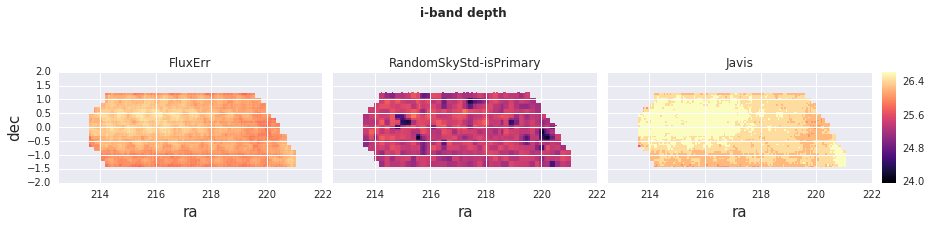

/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


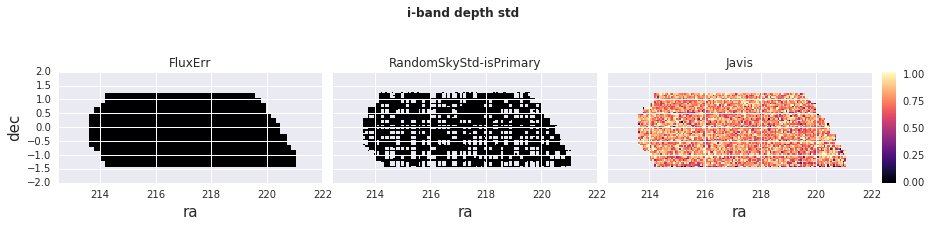

In [16]:
xlabel, ylabel= 'ra', 'dec'
for band in bands:
    # plot the depth for each method.
    fig = plt.figure(figsize=(15, 10))
    # set up for colorbar
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(1,3), axes_pad=0.15, share_all= True, cbar_location="right",
                     cbar_mode="single", cbar_size="5%", cbar_pad=0.15,
                     )
    # since have three maps, need colorange that ~works for all.
    colorMin= 100
    colorMax= -100
    for mInd, method in enumerate(old_depthMap):
        ind= np.where(old_depthMap[method][band]>0)[0]
        colorMin= min(colorMin, np.percentile(old_depthMap[method][band][ind], 0))
        colorMax= max(colorMin, np.percentile(old_depthMap[method][band][ind], 95))
    # plot
    for mInd, method in enumerate(old_depthMap):
        ax= grid[mInd]
        image= ax.imshow(old_depthMap[method][band].reshape([flatSkyGrid.ny,flatSkyGrid.nx]),
                         origin='lower', interpolation='nearest',
                         aspect='equal', extent=[flatSkyGrid.x0, flatSkyGrid.xf, flatSkyGrid.y0, flatSkyGrid.yf],
                         vmin= colorMin, vmax= colorMax, cmap= cmap)
        ax.set_title(method)
        ax.set_xlabel(xlabel,fontsize=15)
        ax.set_ylabel(ylabel,fontsize=15)
        ax.cax.colorbar(image)
        ax.cax.toggle_label(True)
    plt.suptitle('%s-band depth'%band, fontweight="bold", )
    plt.subplots_adjust(top=1.5)
    plt.show()
    
    # plot std similar to depth plots above.
    fig = plt.figure(figsize=(15, 10))
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(1,3), axes_pad=0.15, share_all= True, cbar_location="right",
                     cbar_mode="single", cbar_size="5%", cbar_pad=0.15,
                     )
    colorMin= 100
    colorMax= -100
    for mInd, method in enumerate(old_depthMap):
            ind= np.where(old_depthMap_var[method][band]>0)[0]
            colorMin= min(colorMin, np.percentile(depthMap_var[method][band][ind], 0))
            colorMax= max(colorMin, np.percentile(depthMap_var[method][band][ind], 95))
            
    for mInd, method in enumerate(old_depthMap):
        ax= grid[mInd]
        image= ax.imshow(old_depthMap_var[method][band].reshape([flatSkyGrid.ny,flatSkyGrid.nx]),
                         origin='lower', interpolation='nearest',
                         aspect='equal', extent=[flatSkyGrid.x0, flatSkyGrid.xf, flatSkyGrid.y0, flatSkyGrid.yf],
                         vmin= colorMin, vmax= colorMax, cmap= cmap)
        ax.set_title(method)
        ax.set_xlabel(xlabel,fontsize=15)
        ax.set_ylabel(ylabel,fontsize=15)
        ax.cax.colorbar(image)
        ax.cax.toggle_label(True)
    plt.suptitle('%s-band depth std'%band, fontweight="bold", )
    plt.subplots_adjust(top=1.5)
    plt.show()

#### Ok so the overall structure looks comparable as before.

In [17]:
# np.degrees(hp.nside2resol(1024))